### Load modules and read data

In [26]:
import feets.preprocess
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv('./Data/training_set.csv')
df.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


* Object ID: identifier for an astronomical object
* mjd: a date
* passband: bandwidth groups for a curve
* flux: brightness
* flux_err: flux error

In [3]:
df_meta = pd.read_csv('./Data/training_set_metadata.csv')
df_meta.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


* target acts as the class label

In [4]:
df = df.merge(df_meta, on = 'object_id')
print(df.shape)
df.head()

(1421705, 17)


,object_id,mjd,passband,flux,flux_err,detected,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,59750.4229,2,-544.810303,3.622952,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
1,615,59750.4306,1,-816.434326,5.553370,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
2,615,59750.4383,3,-471.385529,3.801213,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
3,615,59750.4450,4,-388.984985,11.395031,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
4,615,59752.4070,2,-681.858887,4.041204,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92


### Analyses

In [5]:
df['target'].value_counts()

90    465046
42    212447
65    185894
16    147474
62     87079
88     70622
15     64440
92     41985
67     39887
52     37480
95     30712
6      20830
64     13418
53      4391
Name: target, dtype: int64

In [6]:
def plot_light_curve(oid):
    """Plot a light curve given an object's ID
    Parameters:
        oid (int): object ID
    Returns:
        None"""
    
    data = df[df['object_id'] == oid]
    
    plt.scatter(data['mjd'], data['flux'], color = '#552583')
    plt.title('Light Curve for Object {}'.format(oid))
    plt.xlabel('MJD')
    plt.ylabel('Flux')
    plt.show()
    plt.close()

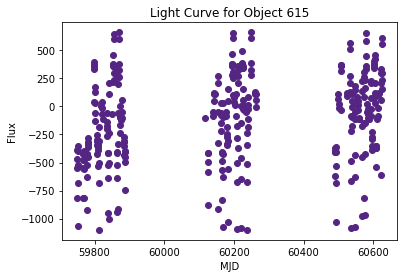

In [7]:
plot_light_curve(615)

Feature extraction:

In [8]:
lc = df.loc[:, ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'target']]
print(lc.shape)
lc.head()

(1421705, 6)


,object_id,mjd,passband,flux,flux_err,target
0,615,59750.4229,2,-544.810303,3.622952,92
1,615,59750.4306,1,-816.434326,5.553370,92
2,615,59750.4383,3,-471.385529,3.801213,92
3,615,59750.4450,4,-388.984985,11.395031,92
4,615,59752.4070,2,-681.858887,4.041204,92


In [9]:
lc['object_id'].value_counts()

615          352
173059       352
167417       352
167436       352
167488       352
            ... 
100413487     55
68643457      52
119353712     52
86237249      50
49575267      47
Name: object_id, Length: 7848, dtype: int64

Compute features:

In [14]:
# features to calculate using feets
feature_names = ['Amplitude', 'AndersonDarling', 'MaxSlope', 'Mean', 'Meanvariance', 'MedianAbsDev', 'Rcs', 'Skew', 'Std']

# compute features - iterate over each object ID over time
object_ids = lc['object_id'].unique()
passband = 0

feature_values = np.zeros((len(object_ids), len(feature_names) - 1))  # something breaks for MaxSlope
targets = np.zeros(len(object_ids))

feature_values.shape

for idx, o in enumerate(object_ids):
    fil_data = lc[(lc['object_id'] == o) & (lc['passband'] == passband)]  # filter data
    feets_ip = [fil_data['mjd'], fil_data['flux'], fil_data['flux_err']]
    
    fs = feets.FeatureSpace(data = ['date', 'magnitude', 'error'], only = feature_names)
    
    features, values = fs.extract(*feets_ip)
    
    feature_values[idx, :] = values
    targets[idx] = fil_data.iloc[0, -1]

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
c:\users\samar\appdata\local\programs\python\python38\lib\site-packages\feets\extractors\core.py:234: ExtractorWarning

In [24]:
prep_data = np.c_[object_ids, feature_values, targets]

lc_feats = pd.DataFrame(prep_data, columns = ['object_id', 'Amplitude', 'AndersonDarling', 'Mean', 'Meanvariance', 'MedianAbsDev', 'Rcs', 'Skew', 'Std', 'target'])
lc_feats.head()

,object_id,Amplitude,AndersonDarling,Mean,Meanvariance,MedianAbsDev,Rcs,Skew,Std,target
0,615.0,117.660498,1.000000,-3.254554,-25.587479,79.958667,0.294085,0.125827,83.275842,92.0
1,713.0,11.347079,0.999936,-2.720398,-2.596133,6.054598,0.436782,0.254446,7.062516,88.0
2,730.0,3.302110,0.362424,-0.048080,-37.772702,1.205846,0.086680,0.349431,1.816127,42.0
3,745.0,9.511895,1.000000,1.797523,2.416637,1.720855,0.282359,1.980815,4.343961,90.0
4,1124.0,4.585307,0.538771,0.660948,3.542304,1.365366,0.206023,-0.324207,2.341279,90.0


### Logistic Regression

In [29]:
X = lc_feats[['Amplitude', 'AndersonDarling']]
y = lc_feats['target']

logr = LogisticRegression(multi_class = 'auto', solver = 'liblinear')

logr.fit(X, y)

preds = logr.predict(X)

f1_score(y, preds, average = 'weighted')

0.14494296188734537